## Python version

In [1]:
from platform import python_version
print(python_version())

3.6.5


## Import Libraries

In [2]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf

# https://www.kdnuggets.com/2018/02/google-colab-free-gpu-tutorial-tensorflow-keras-pytorch.html/2
# https://pypi.org/project/pyramid-arima/
!pip install -q pyramid-arima==0.9.0

from numpy.random import seed
seed(1)
from pandas import DataFrame
from pyramid.arima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts


dtypes = {
        'IsCanceled':                                    'float64',
        'LeadTime':                                          'float64',
        'StaysInWeekendNights':                                     'float64',
        'StaysInWeekNights':                                     'float64',
        'Adults':                            'float64',
        'Children':                            'float64',
        'Babies':                                  'float64',
        'Meal':                                    'category',
        'Country':                                               'category',
        'MarketSegment':                                    'category',
        'DistributionChannel':                                       'category',
        'IsRepeatedGuest':                               'float64',
        'PreviousCancellations':                                    'float64',
        'PreviousBookingsNotCanceled':                          'float64',
        'ReservedRoomType':                                             'category',
        'AssignedRoomType':                                            'category',
        'BookingChanges':                                                'float64',
        'DepositType':                                              'category',
        'Agent':                                              'category',
        'Company':                                 'category',
        'DaysInWaitingList':                                           'float64',
        'CustomerType':                                           'category',
        'ADR':                                          'float64',
        'RequiredCarParkingSpaces':                                      'float64',
        'TotalOfSpecialRequests':                                              'float64',
        'ReservationStatus':                                                'category'
        }

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


/home/michael/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/home/michael/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/michael/.local/lib/python3.6/site-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is du

## Data Import and Manipulation

In [3]:
train_df = pd.read_csv('H2full.csv', dtype=dtypes, converters={'ArrivalDateWeekNumber': '{:0>2}'.format})
a=train_df.head()
b=train_df
b
c=b.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)
c=pd.DataFrame(c)
c
type(c)

pandas.core.frame.DataFrame

In [4]:
df = DataFrame(c, columns= ['ArrivalDateYear', 'ArrivalDateWeekNumber']) 
df

,ArrivalDateYear,ArrivalDateWeekNumber
0,2015,27
1,2015,27
2,2015,27
3,2015,27
4,2015,27
...,...,...
79325,2017,35
79326,2017,35
79327,2017,35
79328,2017,35


In [5]:
# https://datatofish.com/concatenate-values-python/

df1 = df['ArrivalDateYear'].map(str) + df['ArrivalDateWeekNumber'].map(str)
print (df1)
df1=pd.DataFrame(df1)

0        201527
1        201527
2        201527
3        201527
4        201527
          ...  
79325    201735
79326    201735
79327    201735
79328    201735
79329    201735
Length: 79330, dtype: object


In [6]:
df2 = DataFrame(c, columns= ['IsCanceled']) 
df2

,IsCanceled
0,0.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
79325,0.0
79326,0.0
79327,0.0
79328,0.0


In [7]:
type(df1)

pandas.core.frame.DataFrame

In [8]:
df3=pd.concat([df1, df2], axis = 1)
df3
df3.columns = ['FullDate', 'IsCanceled']

In [9]:
df3
df3.sort_values(['FullDate','IsCanceled'], ascending=True)

,FullDate,IsCanceled
0,201527,0.0
6,201527,0.0
10,201527,0.0
11,201527,0.0
12,201527,0.0
...,...,...
33650,201735,1.0
33651,201735,1.0
33652,201735,1.0
33653,201735,1.0


In [10]:
df4 = df3.groupby('FullDate').agg(sum)
df4
df4.sort_values(['FullDate'], ascending=True)

,IsCanceled
FullDate,
201527,97.0
201528,153.0
201529,228.0
201530,321.0
201531,159.0
...,...
201731,253.0
201732,269.0
201733,341.0


In [11]:
tseries=df4['IsCanceled']
tseries

FullDate
201527     97.0
201528    153.0
201529    228.0
201530    321.0
201531    159.0
          ...  
201731    253.0
201732    269.0
201733    341.0
201734    201.0
201735    129.0
Name: IsCanceled, Length: 115, dtype: float64

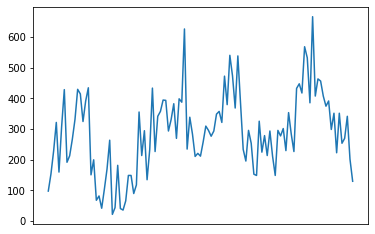

In [12]:
plt.plot(tseries)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

In [13]:
df=pd.DataFrame(tseries)
df

,IsCanceled
FullDate,
201527,97.0
201528,153.0
201529,228.0
201530,321.0
201531,159.0
...,...
201731,253.0
201732,269.0
201733,341.0


## Train-Test Split

In [14]:
tseriesr=pd.Series(tseries)
type(tseriesr)

# logvalue=np.log(tseriesr)
train, val = tseriesr[1:80], tseriesr[81:100]

In [15]:
type(val)

pandas.core.series.Series

In [16]:
train

FullDate
201528    153.0
201529    228.0
201530    321.0
201531    159.0
201532    308.0
          ...  
201649    295.0
201650    253.0
201651    152.0
201652    148.0
201653    325.0
Name: IsCanceled, Length: 79, dtype: float64

In [17]:
val

FullDate
201702    278.0
201703    213.0
201704    293.0
201705    211.0
201706    148.0
201707    295.0
201708    277.0
201709    301.0
201710    229.0
201711    353.0
201712    283.0
201713    226.0
201714    432.0
201715    447.0
201716    417.0
201717    568.0
201718    532.0
201719    385.0
201720    666.0
Name: IsCanceled, dtype: float64

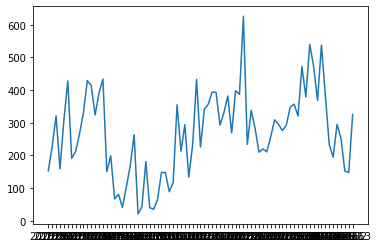

In [18]:
plt.plot(train)
plt.show()

### Autocorrelation Plot

/home/michael/.local/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


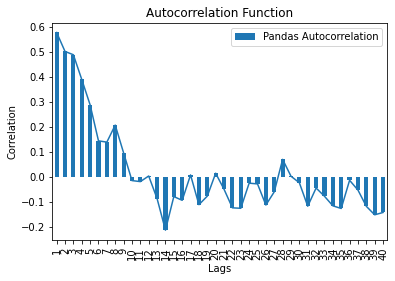

In [19]:
acf_1 =  acf(train)[1:50]
val_df = pd.DataFrame([acf_1]).T
val_df.columns = ['Pandas Autocorrelation']
val_df.index += 1
val_df.plot(kind='bar')
plt.plot(acf_1)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title(r'Autocorrelation Function')
plt.show()

In [20]:
acf_1

array([ 0.57682569,  0.50102825,  0.48783442,  0.38911865,  0.28749014,
        0.14347525,  0.13845609,  0.20647123,  0.09543422, -0.01532162,
       -0.01949013,  0.00295344, -0.08714255, -0.21361621, -0.07932248,
       -0.09418838,  0.00732071, -0.11172859, -0.07741976,  0.01403797,
       -0.04999613, -0.12427111, -0.12616096, -0.02565199, -0.02869097,
       -0.11310648, -0.06031756,  0.06947717,  0.00204902, -0.02404939,
       -0.11781334, -0.04500863, -0.07799972, -0.11624471, -0.12687692,
       -0.01416571, -0.05323403, -0.1182098 , -0.15217874, -0.14281422])

### Partial Autocorrelation Plot

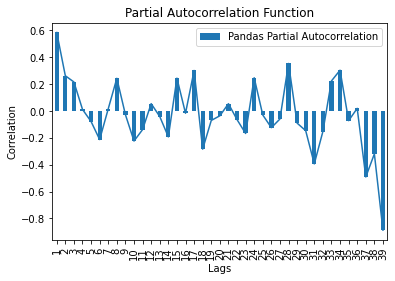

In [21]:
pacf_1 =  pacf(train)[1:40]
val_df = pd.DataFrame([pacf_1]).T
val_df.columns = ['Pandas Partial Autocorrelation']
val_df.index += 1
val_df.plot(kind='bar')
plt.plot(pacf_1)
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.title(r'Partial Autocorrelation Function')
plt.show()

In [22]:
pacf_1

array([ 0.5842209 ,  0.26223107,  0.21573143,  0.01189639, -0.07843622,
       -0.21261607,  0.01648512,  0.24328135, -0.02710635, -0.22364443,
       -0.13830762,  0.05450444, -0.04117697, -0.19265721,  0.2444511 ,
       -0.01668242,  0.30164693, -0.28390422, -0.07043485, -0.03570086,
        0.0544023 , -0.0639319 , -0.16727779,  0.24730303, -0.02973084,
       -0.12405868, -0.05959775,  0.35373697, -0.09018903, -0.14640566,
       -0.39377109, -0.15330695,  0.22351772,  0.30356455, -0.07185584,
        0.01957683, -0.49110331, -0.3190555 , -0.88703165])

### Dickey-Fuller Test

In [23]:
result = ts.adfuller(train)
result
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.793269
p-value: 0.383808
Critical Values:
	1%: -3.526
	5%: -2.903
	10%: -2.589


## ARIMA Model Configuration

In [24]:
Arima_model=auto_arima(train, start_p=0, start_q=0, max_p=10, max_q=10, start_P=0, start_Q=0, max_P=10, max_Q=10, m=52, seasonal=True, trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=343.356, BIC=345.872, Fit time=0.401 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=344.428, BIC=349.460, Fit time=59.130 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=343.219, BIC=348.251, Fit time=53.532 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 52); AIC=345.009, BIC=351.300, Fit time=74.184 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=341.640, BIC=345.414, Fit time=2.725 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=341.033, BIC=346.066, Fit time=4.195 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=343.198, BIC=346.972, Fit time=1.881 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 0, 52); AIC=342.822, BIC=349.112, Fit time=7.440 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 0, 52); AIC=345.584, BIC=353.133, Fit time=6.923 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(

In [25]:
Arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   79
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 52)   Log Likelihood                -166.517
Date:                             Fri, 29 May 2020   AIC                            341.033
Time:                                     15:45:12   BIC                            346.066
Sample:                                          0   HQIC                           342.482
                                              - 79                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.5234      3.763      1.202      0.229      -2.851      11.898
ar.L1          0.4275      0.361      1.185      0.236      -0.279       1.135
ma.L1         -0.9972      7.514     -0.133      0.894     -15.724      13.730
sigma2       1.95e+04   1.47e+05      0.133      0.894   -2.68e+05    3.07e+05
===================================================================================
Ljung-Box (Q):                       21.85   Jarque-Bera (JB):                 3.34
Prob(Q):                              0.64   Prob(JB):                         0.19
Heteroskedasticity (H):               1.35   Skew:                             0.88
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
prediction=pd.DataFrame(Arima_model.predict(n_periods=19), index=val.index)
prediction.columns = ['Predicted_Cancellations']
predictions=prediction['Predicted_Cancellations']

In [27]:
prediction

,Predicted_Cancellations
FullDate,
201702,281.584707
201703,299.683766
201704,382.118948
201705,386.400852
201706,333.754954
201707,368.995019
201708,614.613874
201709,480.394679
201710,569.244726


In [28]:
val

FullDate
201702    278.0
201703    213.0
201704    293.0
201705    211.0
201706    148.0
201707    295.0
201708    277.0
201709    301.0
201710    229.0
201711    353.0
201712    283.0
201713    226.0
201714    432.0
201715    447.0
201716    417.0
201717    568.0
201718    532.0
201719    385.0
201720    666.0
Name: IsCanceled, dtype: float64

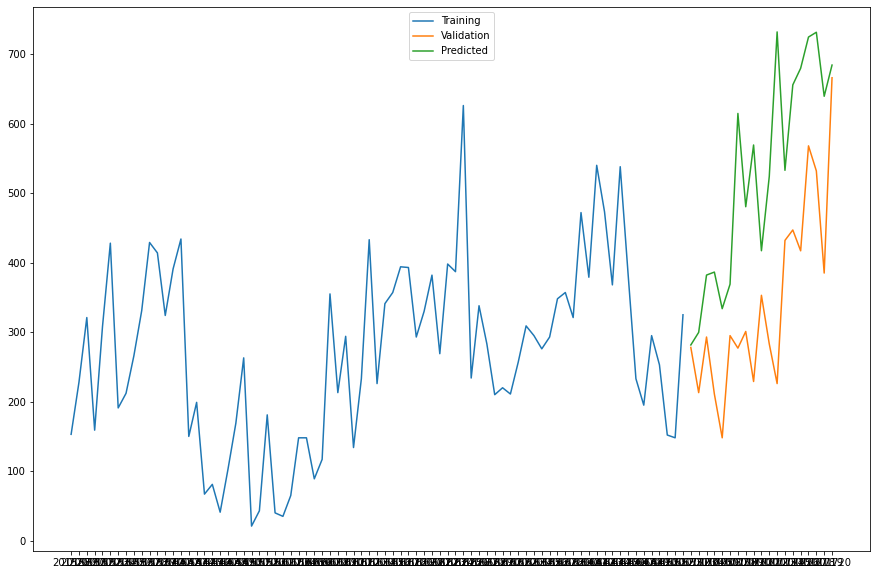

In [29]:
plt.figure(figsize=(15,10))
plt.plot(train, label='Training')
plt.plot(val, label='Validation')
plt.plot(prediction, label='Predicted')
plt.legend(loc = 'upper center')
plt.show()

In [30]:
import numpy as np

def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [31]:
type(predictions)

pandas.core.series.Series

In [32]:
mda(val, predictions)

0.8947368421052632

In [33]:
mse = mean_squared_error(val, predictions)
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 219.840700


## Validate Predictions on Test Data

In [34]:
test = np.array([[407,463,456,407,374,391,298,351,222,351,253,269,341,201,129]])
test.shape

(1, 15)

In [35]:
test=test.reshape(-1)
test

array([407, 463, 456, 407, 374, 391, 298, 351, 222, 351, 253, 269, 341,
       201, 129])

In [36]:
test.shape

(15,)

In [37]:
test = pd.Series(test)

In [38]:
predictionnew=pd.DataFrame(Arima_model.predict(n_periods=15), index=test.index)
predictionnew.columns = ['Unseen_Predicted_Cancellations']
predictionsnew=predictionnew['Unseen_Predicted_Cancellations']

In [39]:
mse_new = mean_squared_error(test, predictionsnew)
rmse_new = math.sqrt(mse_new)
print('RMSE: %f' % rmse_new)

RMSE: 274.080786


In [40]:
mda(test, predictionsnew)

0.8666666666666667

In [41]:
forecast_error_new = (predictionsnew-test)
forecast_error_new

0    -125.415293
1    -163.316234
2     -73.881052
3     -20.599148
4     -40.245046
5     -22.004981
6     316.613874
7     129.394679
8     347.244726
9      66.124377
10    271.016685
11    462.914404
12    191.814437
13    454.715459
14    550.616904
dtype: float64

In [42]:
mean_forecast_error_new = np.mean(forecast_error_new)
mean_forecast_error_new

156.33291942460139

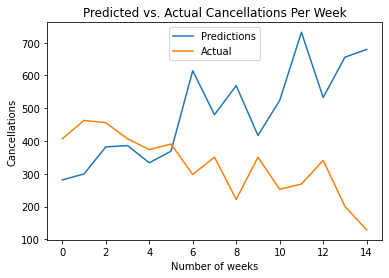

In [43]:
predictons, =plt.plot(predictionsnew, label='Predictions')
actual, =plt.plot(test, label='Actual')
plt.xlabel('Number of weeks')
plt.ylabel('Cancellations')
plt.title("Predicted vs. Actual Cancellations Per Week")
plt.legend(loc = 'upper center')
plt.show()